# Duffing Equation
The Duffing equation (or Duffing oscillator), named after Georg Duffing (1861–1944), is a non-linear second-order differential equation used to model certain damped and driven oscillators. The equation is given by


\begin{align*}
{\ddot {x}}+\delta {\dot {x}}+\alpha x+\beta x^{3}=\gamma \cos(\omega t)
\end{align*}

where the (unknown) function $x=x(t)$ is the displacement at time t, $ {\dot {x}}$ is the first derivative of $x$ with respect to time, i.e. velocity, and ${\ddot {x}}$ is the second time-derivative of $x$ i.e. acceleration. The numbers
$\delta, \alpha, \beta, \gamma$ and $\omega$ are given constants.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

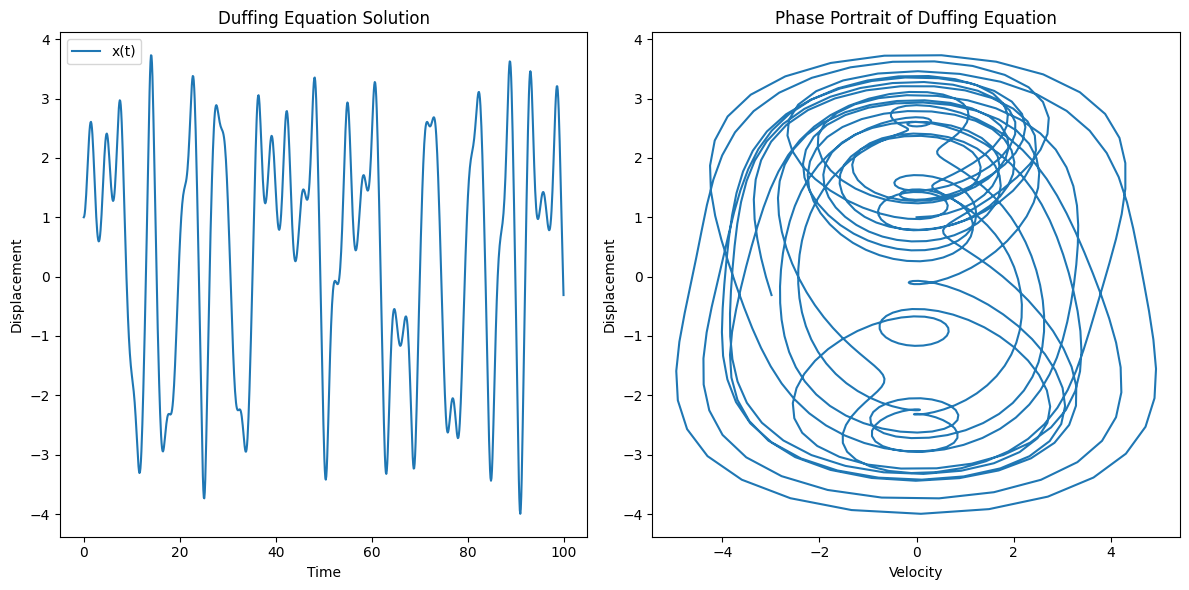

In [4]:
def duffing(t, y, delta, alpha, beta, gamma, omega):
    x, v = y
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return np.array([dxdt, dvdt])

# Simulation parameters
delta = 0.1
alpha = -1.0
beta = 0.25
gamma = 2.5
omega = 2

# Initial conditions
x0 = 1.0
v0 = 0.0
y0 = [x0, v0]

# Run the simulation
# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the Duffing equation
sol = solve_ivp(duffing, t_span, y0, args=(delta, alpha, beta, gamma, omega), t_eval=t_eval)

# Plot the solution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Duffing Equation Solution')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(sol.y[1], sol.y[0])
plt.xlabel('Velocity')
plt.ylabel('Displacement')
plt.title('Phase Portrait of Duffing Equation')

plt.tight_layout()
plt.show()

[ 1.          1.00016244  1.00064951 ... -0.22069631 -0.25087605
 -0.28093746]
[ 0.90663071  1.00102008  0.97006104 ... -0.06040053 -0.07931231
 -0.09705503]
165.4170721453655


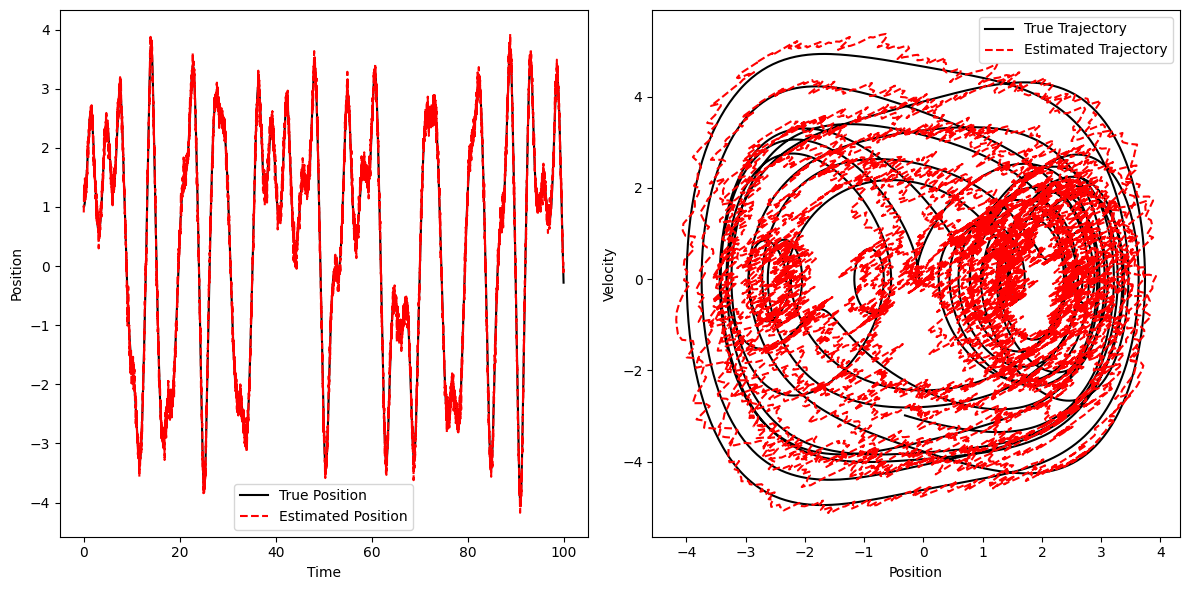

In [5]:
# Define the Duffing equation dynamics and Jacobian
def duffing_dynamics(t, state, delta, alpha, beta, gamma, omega):
    x, v = state
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return np.array([dxdt, dvdt])

def duffing_jacobian(state, delta, alpha, beta, gamma, omega):
    x, v = state
    return np.array([
        [0, 1],
        [-alpha - 3 * beta * x**2, -delta]
    ])

# Extended Kalman Filter Prediction and Update Steps
def ekf_predict(x, P, Q, dt, delta, alpha, beta, gamma, omega, t):
    f = duffing_dynamics(t, x, delta, alpha, beta, gamma, omega) * dt
    x_pred = x + f
    F = duffing_jacobian(x, delta, alpha, beta, gamma, omega)
    F_dt = np.eye(len(x)) + F * dt
    P_pred = F_dt @ P @ F_dt.T + Q
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, z, R, H):
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ H @ P_pred
    return x_upd, P_upd

# Simulation settings
t0, t1, dt = 0, 100, 0.01
delta, alpha, beta, gamma, omega = 0.1, -1.0, 0.25, 2.5, 2
x0 = [1.0, 0.0]

# Generate true trajectory
t_eval = np.arange(t0, t1 + dt, dt)
sol = solve_ivp(lambda t, y: duffing_dynamics(t, y, delta, alpha, beta, gamma, omega),
                [t0, t1], x0, t_eval=t_eval, method='RK45')

# Initial conditions for EKF
x_est = np.array(x0)
P_est = np.eye(2) * 0.1
Q = np.eye(2) * 0.01
R = np.array([[0.1]])
H = np.array([[1, 0]])

# Arrays to store estimates
x_estimates = []

# Run EKF
for idx, t in enumerate(t_eval[:-1]):
    x_pred, P_pred = ekf_predict(x_est, P_est, Q, dt, delta, alpha, beta, gamma, omega, t)
    z = np.array([sol.y[0, idx] + np.random.normal(0, np.sqrt(R[0, 0]))])
    x_est, P_est = ekf_update(x_pred, P_pred, z, R, H)
    x_estimates.append(x_est)

x_estimates = np.array(x_estimates)

# ==========
print(sol.y[0, :-1])
print("============")
print(x_estimates[:, 0])
squared_diff = (sol.y[0, :-1] - x_estimates[:, 0])**2
squared_sum_diff = np.sum(squared_diff)
print(squared_sum_diff)


# Plotting the estimated and true positions over time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t_eval[:-1], sol.y[0, :-1], 'k', label='True Position')
plt.plot(t_eval[:-1], x_estimates[:, 0], 'r--', label='Estimated Position')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

# Plotting phase portrait
plt.subplot(1, 2, 2)
plt.plot(sol.y[0], sol.y[1], 'k', label='True Trajectory')
plt.plot(x_estimates[:, 0], x_estimates[:, 1], 'r--', label='Estimated Trajectory')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()


249.35223485133082


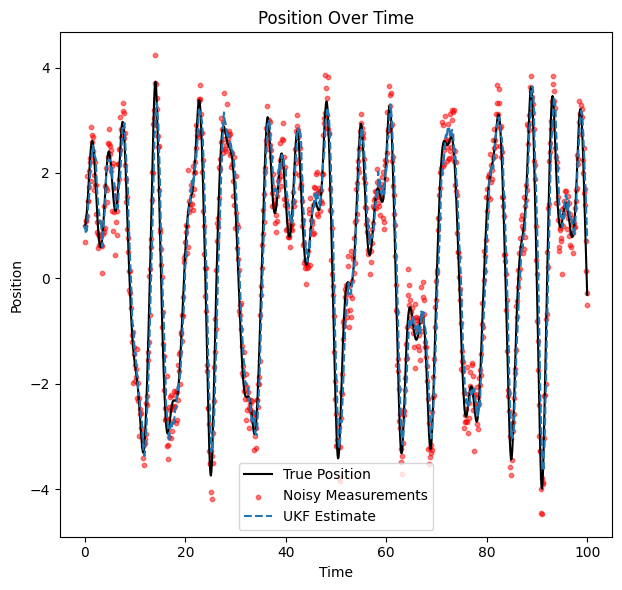

In [7]:
def duffing_dynamics(t, state, delta, alpha, beta, gamma, omega):
    x, v = state
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return np.array([dxdt, dvdt])  # Use this for differential equation solving

def propagate_dynamics(state, dt, delta, alpha, beta, gamma, omega):
    # Propagate the dynamics forward by one time step using simple Euler integration
    deriv = duffing_dynamics(0, state, delta, alpha, beta, gamma, omega)
    return state + deriv * dt

def generate_sigma_points(x, P, alpha, ki, beta):
    n = len(x)
    lambda_ = alpha**2 * (n + ki) - n
    sigma_points = np.zeros((2 * n + 1, n))
    wm = np.zeros(2 * n + 1)
    wc = np.zeros(2 * n + 1)
    c = np.sqrt(n + lambda_)
    W = c * np.linalg.cholesky(P)
    sigma_points[0] = x
    for i in range(n):
        sigma_points[i + 1] = x + W[:, i]
        sigma_points[n + i + 1] = x - W[:, i]
    wm.fill(1 / (2 * (n + lambda_)))
    wc.fill(1 / (2 * (n + lambda_)))
    wm[0] = lambda_ / (n + lambda_)
    wc[0] = lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    return sigma_points, wm, wc

def ukf_predict(sigma_points, wm, wc, Q, dt, delta, alpha, beta, gamma, omega):
    n = sigma_points.shape[1]
    sigma_points_pred = np.zeros_like(sigma_points)
    for i in range(sigma_points.shape[0]):
        sigma_points_pred[i] = propagate_dynamics(sigma_points[i], dt, delta, alpha, beta, gamma, omega)
    x_pred = np.dot(wm, sigma_points_pred)
    P_pred = Q.copy()
    for i in range(2 * n + 1):
        diff = sigma_points_pred[i] - x_pred
        P_pred += wc[i] * np.outer(diff, diff)
    return x_pred, P_pred, sigma_points_pred

def ukf_update(x_pred, P_pred, sigma_points_pred, z, R, H, wm, wc):
    n = x_pred.shape[0]
    zs = np.dot(H, sigma_points_pred.T)
    z_pred = np.dot(wm, zs.T)
    Pz = R.copy()
    for i in range(2 * n + 1):
        diff = zs[:, i] - z_pred
        Pz += wc[i] * np.outer(diff, diff)
    Pxz = np.zeros((n, H.shape[0]))
    for i in range(2 * n + 1):
        Pxz += wc[i] * np.outer(sigma_points_pred[i] - x_pred, zs[:, i] - z_pred)
    K = np.dot(Pxz, np.linalg.inv(Pz))
    x_upd = x_pred + np.dot(K, (z - z_pred))
    P_upd = P_pred - np.dot(K, np.dot(Pz, K.T))
    return x_upd, P_upd

# Simulation parameters
delta, alpha, beta, gamma, omega = 0.1, -1.0, 0.25, 2.5, 2
dt = 0.01
x_ukf = np.array([1.0, 0.0])
P_ukf = np.eye(2) * 0.1
Q = np.eye(2) * 0.01
R = np.array([[0.1]])
H = np.array([[1, 0]])

# Solve the Duffing equation using a solver that accounts for the non-linearity
t_eval = np.linspace(0, 100, 1001)
sol = solve_ivp(lambda t, y: duffing_dynamics(t, y, delta, alpha, beta, gamma, omega), [0, 100], x_ukf, t_eval=t_eval)

# UKF processing
sigma_points, wm, wc = generate_sigma_points(x_ukf, P_ukf, 0.001, 0, 2)
ukf_estimates = [x_ukf]
for idx, z in enumerate(sol.y[0] + np.random.normal(0, np.sqrt(R[0, 0]), sol.y[0].shape)):
    x_pred, P_pred, sigma_points_pred = ukf_predict(sigma_points, wm, wc, Q, dt, delta, alpha, beta, gamma, omega)
    x_ukf, P_ukf = ukf_update(x_pred, P_pred, sigma_points_pred, np.array([z]), R, H, wm, wc)
    ukf_estimates.append(x_ukf)
    sigma_points, _, _ = generate_sigma_points(x_ukf, P_ukf, 0.001, 0, 2)  # Regenerate sigma points after update

ukf_estimates = np.array(ukf_estimates)

squared_diff = (sol.y[0] - ukf_estimates[1:, 0])**2
squared_sum_diff = np.sum(squared_diff)
print(squared_sum_diff)

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t_eval, sol.y[0], 'k', label='True Position')
plt.scatter(t_eval, sol.y[0] + np.random.normal(0, np.sqrt(R[0, 0]), sol.y[0].shape), color='red', s=10, alpha=0.5, label='Noisy Measurements')
plt.plot(t_eval, ukf_estimates[1:, 0], linestyle='--', label='UKF Estimate')

plt.title('Position Over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()


plt.tight_layout()
plt.show()